# Physics Constrain Autoencoders

By Joshua C. Agar, Mary Ye

* There are many times where you want to fit spectroscopic data to a model


* Classical fitting methods can be used but break down:
  * When data is noisy
  * There are multiple candidate models
  * Data is high velocity
  * Data is noisy





# Imports Packages

In [2]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
import torch
from tqdm import tqdm
import os
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

from m3_learning.nn.time_series_nn.nn_util import Train, transform_nn
from m3_learning.viz.layout import layout_fig, embedding_maps, latent_generator

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="0"

plt.rcParams.update({'xtick.direction': 'in', 'ytick.direction':'in'})

import os

In [5]:
# # Imports Custom packages
# import AE_tutorial.viz as viz
# import AE_tutorial.util as util
# import AE_tutorial.nn_util as nn_util

# import DeepMatter as dm
# from DeepMatter.spectral_fitters.gaussian import Gaussian
# from DeepMatter.spectral_fitters.voigt import PseudoVoigt
# from DeepMatter.spectral_fitters import nn as dm_nn
# from DeepMatter.rand_util.rand_gen import rand_tensor

# 
# import torch
# import numpy as np
# import matplotlib.pyplot as plt


# import time
# import math
# from DeepMatter.util.torch_util import Dataset_Generator

## Generating some data based on the image
### Define a non-linear function

In [3]:
class Sin_func:

    """
    Class that computes the Sin function
    """

    def __init__(
        self,
        x_vector,
        amp=[0, 1],
        phase=[0, 1],
        frequency=[0, 1],
        size=(1, 1),
        batch_size=1000,
        verbose=False,
        ):
        """

        Args:
            x_vector:
            sd (array, float): range for the standard deviation
            mean (array, float): range for the mean
            amp (array, float): range for the amplitude
            size (tuple): Size of the array first index is number of channels, second is number of functions
            verbose (bool): shows outputs
        """

        self.x_vector = x_vector
        self.batch_size = batch_size

        self.amp = amp
        self.amp_mean = torch.tensor(amp[0] + amp[1]) / 2
        self.amp_sd = torch.sqrt(torch.pow(torch.tensor(amp[1])
                                 - torch.tensor(amp[0]), 2) / 12)

        self.phase = phase
        self.phase_mean = torch.tensor(phase[0] + phase[1]) / 2
        self.phase_sd = torch.sqrt(torch.pow(torch.tensor(phase[1])
                                   - torch.tensor(phase[0]), 2) / 12)

        self.frequency = frequency
        self.frequency_mean = torch.tensor(frequency[0] + frequency[1]) \
            / 2
        self.frequency_sd = \
            torch.sqrt(torch.pow(torch.tensor(frequency[1])
                       - torch.tensor(frequency[0]), 2) / 12)

        self.size = size
        self.verbose = verbose

    def compute(self, params, device='cpu'):
        """

        Args:
            self (object): Returns the instance itself.
            device (string, optional) : Sets the device to do the computation. Default `cpu`, common option `cuda`

        Returns: out (Tensor): spectra.

        """

        if len(params.size()) == 2:
            params = torch.reshape(params, (params.shape[0], 3, -1))

        out = torch.zeros((params.shape[0], self.x_vector.shape[0],
                          self.size[0], self.size[1]))

        params = params.to(device)

        for i in range(self.size[1]):

            if params.ndim == 4:
                _amp = params[:, 0, 0, i]
                _phase = params[:, 0, 1, i]
                _frequency = params[:, 0, 2, i]

            if params.ndim == 3:
                _amp = params[:, 0, i]
                _phase = params[:, 1, i]
                _frequency = params[:, 2, i]

            x_vector = torch.cat(params.shape[0]
                                 * [self.x_vector]).reshape(params.shape[0],
                    -1).to(device)
            x_vector = torch.transpose(x_vector, 0, 1)  # .to(device)

            _out = _amp * torch.sin(2 * torch.tensor(np.pi)
                                    * _frequency * x_vector + _phase)

            out[:, :, 0, i] = torch.transpose(_out, 0, 1)

        return (torch.sum(out, dim=3), out)

    def sampler(self, device='cpu'):
        """

        Args:
            device (str): device where computation happens

        Returns:
            out (Tensor) : Generated spectra
            params (Tensor) : parameters used for generation

        """

        phase = rand_tensor(min=self.phase[0], max=self.phase[1],
                            size=(self.batch_size, self.size[0],
                            self.size[1]))
        frequency = rand_tensor(min=self.frequency[0],
                                max=self.frequency[1],
                                size=(self.batch_size, self.size[0],
                                self.size[1]))
        amp = rand_tensor(min=self.amp[0], max=self.amp[1],
                          size=(self.batch_size, self.size[0],
                          self.size[1]))
        _params = torch.torch.stack((amp, phase, frequency))

        _params = torch.atleast_2d(_params)
        _params = torch.transpose(_params, 0, 1)
        _params = torch.transpose(_params, 1, 2)

        return (self.compute(_params, device=device), _params)


In [7]:
constructor = Sin_func(amp = [.2, 1],  # Sets the amplitude
                      phase = [0, 2*np.pi], # Sets the phase
                      frequency = [0.1, .5], # Sets the frequency
                      x_vector = torch.linspace(0, np.pi, 100), # Sets the x_vector
                      batch_size = 10000) # number of samples to generate

In [8]:
# initializes the constructor
output = constructor.sampler()

# grabs the parameters and the spectra
spectra, params = output

# This grabs the sum of all spectral and the individual spectra if they exist
spectra_full, spectras = spectra

## Visualize and example generated curve

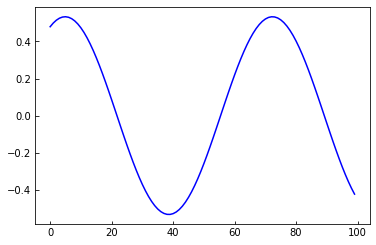

In [9]:
rand = np.random.randint(0,10000)
plt.plot(spectras[rand,:,0].cpu(),'b')

## Recurrent Neural Network Autoencoders
* It is important to consider the temporal domain 
* This can be improved by using a recurrent neural network that processes each time step sequentially.
* To add an understanding about the short and long term information in the data you can add memory and forget logic as a learnable parameter.

![](https://github.com/jagar2/AI_For_Atoms_Autoencoder_Tutorial/blob/main/img/Autoencoder_Med.png?raw=true)

![](https://github.com/jagar2/AI_For_Atoms_Autoencoder_Tutorial/blob/main/img/LSTM%20Node.png?raw=true)

### Builds the autoencoder

In [10]:
class Encoder(nn.Module):

    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(1, 12, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(24, 12, batch_first=True,
                             bidirectional=True)
        self.embedding = nn.Linear(24, self.latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        (x, (_, __)) = self.lstm(x)
        (x, (_, __)) = self.lstm2(x)
        x = x[:, -1, :]
        x = self.embedding(x)
        return x


class Decoder(nn.Module):

    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(self.latent_dim, 12, batch_first=True,
                            bidirectional=True)
        self.lstm2 = nn.LSTM(24, 12, batch_first=True,
                             bidirectional=True)
        self.tdd = nn.Conv1d(24, 1, 1)

    def forward(self, x):
        x = x[:, :, None]
        x = x.transpose(1, 2)
        x = x.repeat([1, 100, 1])
        (x, (_, __)) = self.lstm(x)
        (x, (_, __)) = self.lstm2(x)
        x = x.transpose(1, 2)
        x = self.tdd(x)
        x = x.transpose(1, 2)
        return x


In [11]:
class Autoencoder(nn.Module):

    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):

        # encode

        embedding = self.encoder(x)

        # decode

        predicted = self.decoder(embedding)

        return predicted


Since we know there are intrinsically 3 latent dimensions let's try and train the model.

In [12]:
device = 'cuda'
latent_dim = 3

encoder = Encoder(latent_dim=latent_dim).to(device)
decoder = Decoder(latent_dim=latent_dim).to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer

optimizer = optim.Adam(model.parameters(), lr=3e-5)

In [13]:
# views the model

model

Autoencoder(
  (encoder): Encoder(
    (lstm): LSTM(1, 12, batch_first=True, bidirectional=True)
    (lstm2): LSTM(24, 12, batch_first=True, bidirectional=True)
    (embedding): Linear(in_features=24, out_features=3, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (lstm): LSTM(3, 12, batch_first=True, bidirectional=True)
    (lstm2): LSTM(24, 12, batch_first=True, bidirectional=True)
    (tdd): Conv1d(24, 1, kernel_size=(1,), stride=(1,))
  )
)

In [14]:
# constructs a dataloader for training

dataloader = DataLoader(spectra_full, batch_size=512, shuffle=True,
                        num_workers=0)

In [ ]:
# trains the model

torch.manual_seed(0)
nn_util.Train(
    model,
    encoder,
    decoder,
    dataloader,
    optimizer,
    500,
    )

In [16]:
# # functions used to grab embbedings and predictions


# def transform_nn(data, encoder, decoder):

#     encoded_spectra = encoder(torch.tensor(np.atleast_3d(data),
#                               dtype=torch.float32).to(device))

#     decoded_spectra = decoder(encoded_spectra)

#     encoded_spectra = encoded_spectra.to('cpu')
#     encoded_spectra = encoded_spectra.detach().numpy()
#     decoded_spectra = decoded_spectra.to('cpu')
#     decoded_spectra = decoded_spectra.detach().numpy()
#     return (encoded_spectra, decoded_spectra)

## Visualize the reconstruction

In [17]:
# computes an example reconstruction for a mini batch

(encoded_, decoded_) = transform_nn(next(iter(dataloader)), encoder,
                                    decoder)

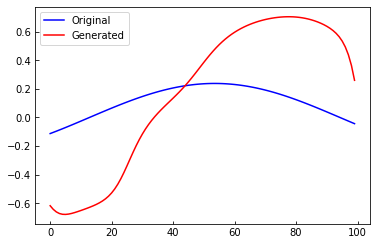

In [18]:
# plots a random example of the original and predicted spectra

rand = np.random.randint(0, 512)
plt.plot(spectras[rand, :, 0].cpu(), 'b', label='Original')
plt.plot(decoded_[rand].squeeze(), 'r', label='Generated')
plt.legend()

## Generating Data as validation
* We want to generate a hyperspectral image
* This can be done by taking the RGB values of an image and using them as parameters for a function

### Loads and image of my dog Nala
* Painting by *Irene Dogmatic*

In [19]:
# Loads dog image

image = io.imread('./nala.jpg')

# Crops dog image

image = image[200:1900:20, 100:1500:20] / 255

## Displays the image

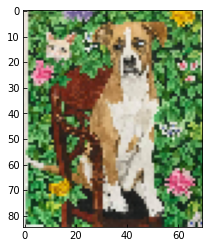

In [20]:
plt.imshow(image)

In [21]:
# Converts the image into parameters withing the generated range

nala_params = np.atleast_3d(image.reshape(-1, 3))

nala_amp = torch.tensor(nala_params[:, 0, 0] * .8 + .2)
nala_phase = torch.tensor(nala_params[:, 1, 0] * 2 * np.pi)
nala_frequency = torch.tensor(nala_params[:, 2, 0] * .5 + .1)

_nala_params = torch.torch.stack((nala_amp, nala_phase, nala_frequency))

_nala_params = torch.atleast_3d(_nala_params)
_nala_params = torch.transpose(_nala_params, 0, 1)

In [22]:
# builds the spectra from the parameters

(nala_spectra, _) = constructor.compute(_nala_params)

# generated the encoded representation and decoded spectra

(nala_encoded_, nala_decoded_) = transform_nn(nala_spectra, encoder,
        decoder)

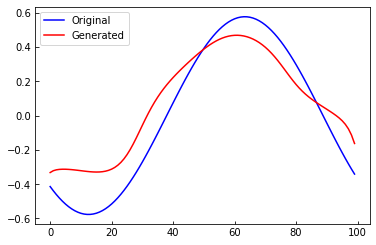

In [23]:
# plots a random example of the origina and predicted spectra

rand = np.random.randint(0, nala_spectra.shape[0])
plt.plot(nala_spectra[rand, :, 0].cpu(), 'b', label='Original')
plt.plot(nala_decoded_[rand].squeeze(), 'r', label='Generated')
plt.legend()


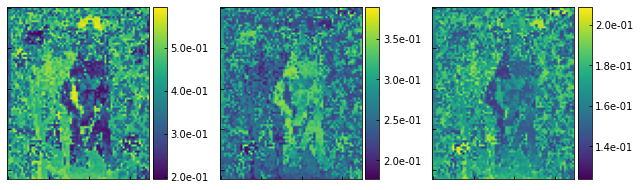

In [24]:
# Visualize the learned embeddings

viz.embedding_maps(nala_encoded_, image)

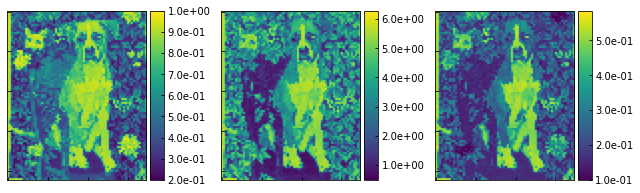

In [25]:
# visualize the actual RGB channels.

viz.embedding_maps(_nala_params.reshape(-1,3), image)

## There is minimal resemblance to the true features

* This is unsurprising because there are no rules that define what the embedding should look like.

# Let's try a bigger model

In [26]:
device = 'cuda'
latent_dim = 12

encoder = Encoder(latent_dim=latent_dim).to(device)
decoder = Decoder(latent_dim=latent_dim).to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer

optimizer = optim.Adam(model.parameters(), lr=3e-5)

In [27]:
# views the model

model

Autoencoder(
  (encoder): Encoder(
    (lstm): LSTM(1, 12, batch_first=True, bidirectional=True)
    (lstm2): LSTM(24, 12, batch_first=True, bidirectional=True)
    (embedding): Linear(in_features=24, out_features=12, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (lstm): LSTM(12, 12, batch_first=True, bidirectional=True)
    (lstm2): LSTM(24, 12, batch_first=True, bidirectional=True)
    (tdd): Conv1d(24, 1, kernel_size=(1,), stride=(1,))
  )
)

In [ ]:
# trains the model

torch.manual_seed(0)
nn_util.Train(
    model,
    encoder,
    decoder,
    dataloader,
    optimizer,
    500,
    )

# Visualize the reconstruction

In [29]:
# computes an example reconstruction for a minibatch

(encoded_, decoded_) = transform_nn(next(iter(dataloader)), encoder,
                                    decoder)

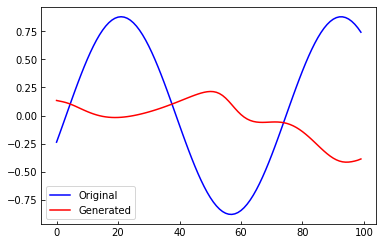

In [30]:
# plots a random example of the origina and predicted spectra

rand = np.random.randint(0, 512)
plt.plot(spectras[rand, :, 0].cpu(), 'b', label='Original')
plt.plot(decoded_[rand].squeeze(), 'r', label='Generated')
plt.legend()

* Reconstruction is slightly better but just more overfit

In [31]:
# builds the spectra from the parameters

(nala_spectra, _) = constructor.compute(_nala_params)

# generated the encoded representation and decoded spectra

(nala_encoded_, nala_decoded_) = transform_nn(nala_spectra, encoder,
        decoder)

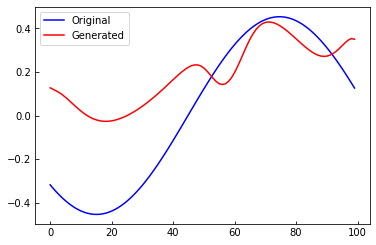

In [32]:
# plots a random example of the origina and predicted spectra

rand = np.random.randint(0, nala_spectra.shape[0])
plt.plot(nala_spectra[rand, :, 0].cpu(), 'b', label='Original')
plt.plot(nala_decoded_[rand].squeeze(), 'r', label='Generated')
plt.legend()


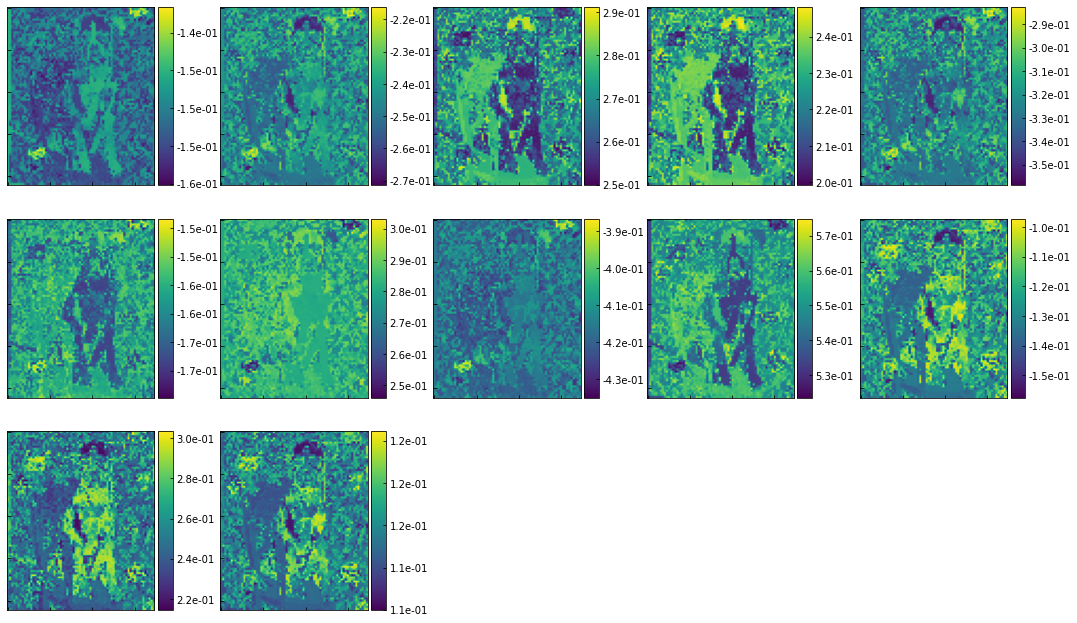

In [33]:
# Visualize the learned embeddings

viz.embedding_maps(nala_encoded_, image)

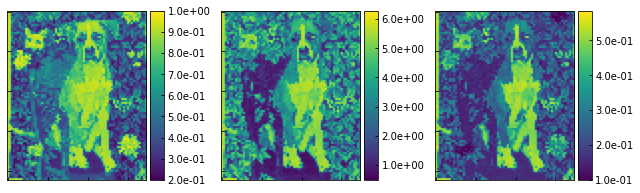

In [34]:
# visualize the actual RGB channels.

viz.embedding_maps(_nala_params.reshape(-1,3), image)

## Now there are just more features but still no resemblance between the parameters.

# Physics constrained neural network

In [35]:
import torch.nn as nn
import torch


class DensePhysLarger(nn.Module):

    def __init__(
        self,
        x_vector,
        model,
        dense_params=3,
        verbose=False,
        device='cuda',
        num_channels=1,
        **kwargs
        ):
        """

        Args:
            x_vector: The vector of values for x
            model: the empirical function to fit
            dense_params: number of output parameters to the model
            verbose: sets if the model is verbose
            device: device where the model will run
            num_channels: number of channels in the input
        """

        super().__init__()
        self.dense_params = dense_params
        self.x_vector = x_vector
        self.verbose = verbose
        self.num_channels = num_channels
        self.device = device
        self.model_params = kwargs.get('model_params')
        self.model = model  # (self.x_vector, size=(num_channels, dense_params // self.model_params))
        self.sigmoid = nn.Sigmoid()
        n = 4

        if torch.cuda.is_available():
            self.cuda()

        # Input block of 1d convolution

        self.hidden_x1 = nn.Sequential(
            nn.Conv1d(in_channels=self.num_channels, out_channels=8
                      * n, kernel_size=7),
            nn.SELU(),
            nn.Conv1d(in_channels=8 * n, out_channels=6 * n,
                      kernel_size=7),
            nn.SELU(),
            nn.Conv1d(in_channels=6 * n, out_channels=4,
                      kernel_size=5),
            nn.SELU(),
            )

        self.hidden_x1_shape = self.hidden_x1(torch.zeros(1,
                self.num_channels, self.x_vector.shape[0])).shape

        # fully connected block

        self.hidden_xfc = \
            nn.Sequential(nn.Linear(self.hidden_x1_shape[1]
                          * self.hidden_x1_shape[2], 20), nn.SELU(),
                          nn.Linear(20, 20), nn.SELU())

           # out of size 20

        self.hidden_xfc_shape = self.hidden_xfc(torch.zeros(1,
                self.hidden_x1_shape[1]
                * self.hidden_x1_shape[2])).shape

        # 2nd block of 1d-conv layers

        self.hidden_x2 = nn.Sequential(
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=1, out_channels=4 * n,
                      kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4 * n, out_channels=4 * n,
                      kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4 * n, out_channels=4 * n,
                      kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4 * n, out_channels=4 * n,
                      kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4 * n, out_channels=4 * n,
                      kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4 * n, out_channels=4 * n,
                      kernel_size=5),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=2),
            nn.Conv1d(in_channels=4 * n, out_channels=2 * n,
                      kernel_size=3),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=2),
            nn.Conv1d(in_channels=2 * n, out_channels=2,
                      kernel_size=3),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=2),
            )

        self.hidden_x2_shape = \
            self.hidden_x2(torch.zeros((self.hidden_xfc_shape[0], 1,
                           self.hidden_x1_shape[1]
                           * self.hidden_x1_shape[2]))).shape

        # Flatten layer

        self.flatten_layer = nn.Flatten()

        # Final embedding block - Output 4 values - linear

        self.hidden_embedding = \
            nn.Sequential(nn.Linear(self.hidden_x2_shape[1]
                          * self.hidden_x2_shape[2]
                          + self.hidden_xfc_shape[1], 16), nn.SELU(),
                          nn.Linear(16, 8), nn.SELU(), nn.Linear(8,
                          self.dense_params))

    def forward(self, x, n=-1):

        x = self.hidden_x1(x)
        xfc = torch.reshape(x, (x.shape[0], -1))  # batch size, features
        xfc = self.hidden_xfc(xfc)
        x = torch.reshape(x, (x.shape[0], 1, self.hidden_x1_shape[1]
                          * self.hidden_x1_shape[2]))
        x = self.hidden_x2(x)
        cnn_flat = self.flatten_layer(x)
        encoded = torch.cat((cnn_flat, xfc), 1)  # merge dense and 1d conv.

        embedding = self.hidden_embedding(encoded)  # output is 3 parameters

        embedding = torch.reshape(embedding, (embedding.shape[0], 3,
                                  -1))

        embedding[:, 0, :] = embedding[:, 0, :] * self.model.amp_sd \
            + self.model.amp_mean
        embedding[:, 1, :] = embedding[:, 1, :] * self.model.phase_sd \
            + self.model.phase_mean
        embedding[:, 2, :] = embedding[:, 2, :] \
            * self.model.frequency_sd + self.model.frequency_mean

        embedding = torch.reshape(embedding, (embedding.shape[0], -1))

        embedding = torch.abs(embedding)
        self.embed = embedding

        (out, _) = self.model.compute(embedding, device=self.device)

        out = torch.transpose(out, 1, 2)
        out = torch.atleast_3d(out)

        return (out.to(self.device), embedding.to(self.device))


In [36]:
x_vector = torch.linspace(0, 10, 100)

model = DensePhysLarger(x_vector, constructor, dense_params=3,
                        model_params=3, verbose=False)

if torch.cuda.is_available():
    model.cuda()


In [37]:
# builds the dataloader

dataloader = DataLoader(torch.transpose(spectra_full,1,2), batch_size=512,
                         shuffle=True, num_workers=0)

In [ ]:
torch.manual_seed(0)

loss_func = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)


epochs = 200
    
for epoch in range(epochs):
  start_time = time.time()

  train_loss = 0.
  total_num = 0

  model.train()
    
  for train_batch in dataloader:
    pred, _ = model(train_batch.cuda())

    optimizer.zero_grad()
    
    loss = loss_func(train_batch.cuda(), pred)
    loss.backward(create_graph=True)
    train_loss += loss.item() * pred.shape[0]
    total_num += pred.shape[0]

    optimizer.step()

  train_loss /= total_num

  print("epoch : {}/{}, recon loss = {:.8f}".format(epoch, epochs, train_loss))
  print("--- %s seconds ---" % (time.time() - start_time))

tensor([0.6210, 3.4364, 0.4780], device='cuda:0', grad_fn=<SelectBackward>)


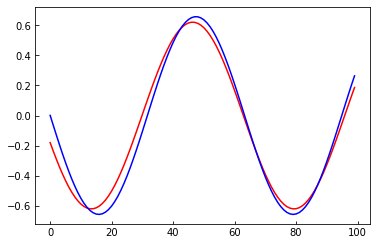

In [45]:
spectra_generated, params = model(train_batch.cuda())
rand = np.random.randint(0,272)
plt.plot(spectra_generated[rand,0,:].detach().cpu().numpy(),'r')
plt.plot(train_batch[rand,0,:],'b')
print(params[rand])

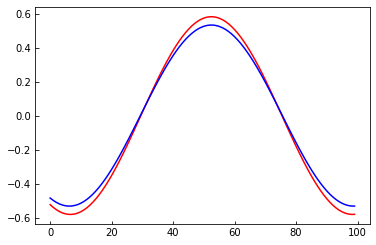

In [63]:
nala_spectra_generated, nala_params = model(nala_spectra.transpose(2,1).cuda())
rand = np.random.randint(0,nala_spectra_generated.shape[0])
plt.plot(nala_spectra_generated[rand,0,:].detach().cpu().numpy(),'r')
plt.plot(nala_spectra[rand,:,0],'b')

In [71]:
nala_params[:,1] = nala_params[:,1] % 2*np.pi

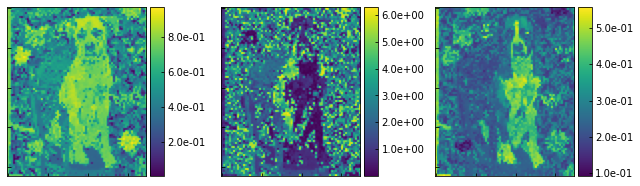

In [72]:
# Visualize the learned embeddings

viz.embedding_maps(nala_params.detach().cpu().numpy(), image)

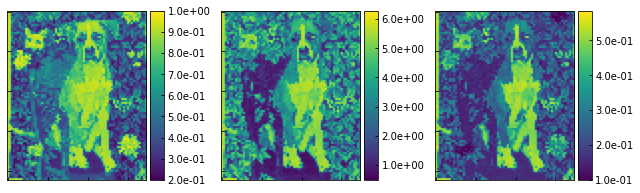

In [67]:
# visualize the actual RGB channels.

viz.embedding_maps(_nala_params.reshape(-1,3), image)

# Try with a better optimizer AdaHessian

In [73]:
"""
Created on Sun Feb 26 16:34:00 2021
@author: Amir Gholami
@coauthor: David Samuel
"""

import numpy as np
import torch

class AdaHessian(torch.optim.Optimizer):
    """
    Implements the AdaHessian algorithm from "ADAHESSIAN: An Adaptive Second OrderOptimizer for Machine Learning"
    Arguments:
        params (iterable) -- iterable of parameters to optimize or dicts defining parameter groups
        lr (float, optional) -- learning rate (default: 0.1)
        betas ((float, float), optional) -- coefficients used for computing running averages of gradient and the squared hessian trace (default: (0.9, 0.999))
        eps (float, optional) -- term added to the denominator to improve numerical stability (default: 1e-8)
        weight_decay (float, optional) -- weight decay (L2 penalty) (default: 0.0)
        hessian_power (float, optional) -- exponent of the hessian trace (default: 1.0)
        update_each (int, optional) -- compute the hessian trace approximation only after *this* number of steps (to save time) (default: 1)
        n_samples (int, optional) -- how many times to sample `z` for the approximation of the hessian trace (default: 1)
    """

    def __init__(self, params, lr=0.1, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.0, 
                 hessian_power=1.0, update_each=1, n_samples=1, average_conv_kernel=False):
        if not 0.0 <= lr:
            raise ValueError(f"Invalid learning rate: {lr}")
        if not 0.0 <= eps:
            raise ValueError(f"Invalid epsilon value: {eps}")
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError(f"Invalid beta parameter at index 0: {betas[0]}")
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError(f"Invalid beta parameter at index 1: {betas[1]}")
        if not 0.0 <= hessian_power <= 1.0:
            raise ValueError(f"Invalid Hessian power value: {hessian_power}")

        self.n_samples = n_samples
        self.update_each = update_each
        self.average_conv_kernel = average_conv_kernel

        # use a separate generator that deterministically generates the same `z`s across all GPUs in case of distributed training
        self.generator = torch.Generator().manual_seed(2147483647)

        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, hessian_power=hessian_power)
        super(AdaHessian, self).__init__(params, defaults)

        for p in self.get_params():
            p.hess = 0.0
            self.state[p]["hessian step"] = 0

    def get_params(self):
        """
        Gets all parameters in all param_groups with gradients
        """

        return (p for group in self.param_groups for p in group['params'] if p.requires_grad)

    def zero_hessian(self):
        """
        Zeros out the accumalated hessian traces.
        """

        for p in self.get_params():
            if not isinstance(p.hess, float) and self.state[p]["hessian step"] % self.update_each == 0:
                p.hess.zero_()

    @torch.no_grad()
    def set_hessian(self):
        """
        Computes the Hutchinson approximation of the hessian trace and accumulates it for each trainable parameter.
        """

        params = []
        for p in filter(lambda p: p.grad is not None, self.get_params()):
            if self.state[p]["hessian step"] % self.update_each == 0:  # compute the trace only each `update_each` step
                params.append(p)
            self.state[p]["hessian step"] += 1

        if len(params) == 0:
            return

        if self.generator.device != params[0].device:  # hackish way of casting the generator to the right device
            self.generator = torch.Generator(params[0].device).manual_seed(2147483647)

        grads = [p.grad for p in params]

        for i in range(self.n_samples):
            zs = [torch.randint(0, 2, p.size(), generator=self.generator, device=p.device) * 2.0 - 1.0 for p in params]  # Rademacher distribution {-1.0, 1.0}
            h_zs = torch.autograd.grad(grads, params, grad_outputs=zs, only_inputs=True, retain_graph=i < self.n_samples - 1)
            for h_z, z, p in zip(h_zs, zs, params):
                p.hess += h_z * z / self.n_samples  # approximate the expected values of z*(H@z)

    @torch.no_grad()
    def step(self, closure=None):
        """
        Performs a single optimization step.
        Arguments:
            closure (callable, optional) -- a closure that reevaluates the model and returns the loss (default: None)
        """

        loss = None
        if closure is not None:
            loss = closure()

        self.zero_hessian()
        self.set_hessian()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None or p.hess is None:
                    continue

                if self.average_conv_kernel and p.dim() == 4:
                    p.hess = torch.abs(p.hess).mean(dim=[2, 3], keepdim=True).expand_as(p.hess).clone()

                # Perform correct stepweight decay as in AdamW
                p.mul_(1 - group['lr'] * group['weight_decay'])

                state = self.state[p]

                # State initialization
                if len(state) == 1:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)  # Exponential moving average of gradient values
                    state['exp_hessian_diag_sq'] = torch.zeros_like(p.data)  # Exponential moving average of Hessian diagonal square values

                exp_avg, exp_hessian_diag_sq = state['exp_avg'], state['exp_hessian_diag_sq']
                beta1, beta2 = group['betas']
                state['step'] += 1

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(p.grad, alpha=1 - beta1)
                exp_hessian_diag_sq.mul_(beta2).addcmul_(p.hess, p.hess, value=1 - beta2)

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']

                k = group['hessian_power']
                denom = (exp_hessian_diag_sq / bias_correction2).pow_(k / 2).add_(group['eps'])

                # make update
                step_size = group['lr'] / bias_correction1
                p.addcdiv_(exp_avg, denom, value=-step_size)

        return loss

In [74]:
x_vector = torch.linspace(0, 10, 100)

model = DensePhysLarger(x_vector, constructor, dense_params=3,
                        model_params=3, verbose=False)

if torch.cuda.is_available():
    model.cuda()


In [75]:
# builds the dataloader

dataloader = DataLoader(torch.transpose(spectra_full,1,2), batch_size=512,
                         shuffle=True, num_workers=0)

In [ ]:
torch.manual_seed(0)

loss_func = torch.nn.MSELoss()

# Use AdaHessian

optimizer = AdaHessian(model.parameters(), lr=0.1)

epochs = 200
    
for epoch in range(epochs):
  start_time = time.time()

  train_loss = 0.
  total_num = 0

  model.train()
    
  for train_batch in dataloader:
    pred, _ = model(train_batch.cuda())

    optimizer.zero_grad()
    
    loss = loss_func(train_batch.cuda(), pred)
    loss.backward(create_graph=True)
    train_loss += loss.item() * pred.shape[0]
    total_num += pred.shape[0]

    optimizer.step()

  train_loss /= total_num

  print("epoch : {}/{}, recon loss = {:.8f}".format(epoch, epochs, train_loss))
  print("--- %s seconds ---" % (time.time() - start_time))

epoch : 0/200, recon loss = 0.16502222
--- 6.810148239135742 seconds ---


In [ ]:
spectra_generated, params = model(train_batch.cuda())
rand = np.random.randint(0,272)
plt.plot(spectra_generated[rand,0,:].detach().cpu().numpy(),'r')
plt.plot(train_batch[rand,0,:],'b')
print(params[rand])

In [ ]:
nala_spectra_generated, nala_params = model(nala_spectra.transpose(2,1).cuda())
rand = np.random.randint(0,nala_spectra_generated.shape[0])
plt.plot(nala_spectra_generated[rand,0,:].detach().cpu().numpy(),'r')
plt.plot(nala_spectra[rand,:,0],'b')

In [ ]:
nala_params[:,1] = nala_params[:,1] % 2*np.pi

In [ ]:
# Visualize the learned embeddings

viz.embedding_maps(nala_params.detach().cpu().numpy(), image)

In [ ]:
# visualize the actual RGB channels.

viz.embedding_maps(_nala_params.reshape(-1,3), image)